# Maximum Likelihood Estimation Tutorial

This is a reading note basicly copy the content of MLE tutorial from QuantEcon.  
Please check [here](https://python.quantecon.org/mle.html) for the whole material.

The tutorial first introduces Poisson distribution.  
Then conditional distribution introduces so-called Possion regression model.  
Then by showing the Poisson joint distribution, we can have a basic concept of what's the purpose of MLE.

To solve MLE problem, this tutorial utilize Newton-Raphson method to find root value where 1st devirative equals to 0.  
Finally, use statsmodels library to solve Poisson regression problem to check the result.

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.api import Poisson
from statsmodels.iolib.summary2 import summary_col
from scipy.special import factorial
from scipy import stats
from scipy.stats import norm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

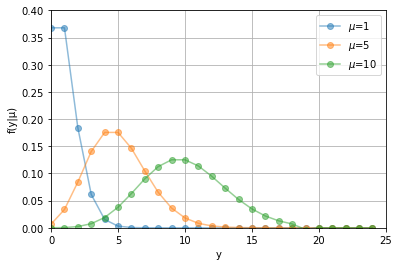

In [2]:
# Poisson distribution over y with different μ values
poisson_pmf = lambda y, μ: μ ** y * np.exp(-μ) / factorial(y)
y_values = np.arange(25)
for μ in (1, 5, 10):
    dist = [poisson_pmf(y, μ) for y in y_values]
    plt.plot(y_values, dist, label=f'$\mu$={μ}', alpha=0.5, marker='o')
plt.grid(); plt.legend();
plt.xlabel('y'); plt.ylabel('f(y|μ)');
plt.axis(xmin=0, xmax=25, ymin=0, ymax=0.4)
plt.show()

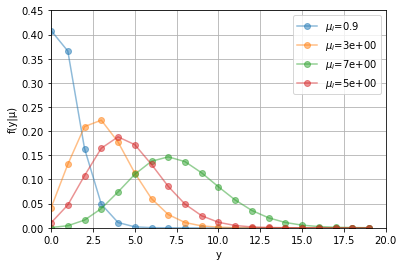

In [3]:
# Conditional distribution
# yi is conditional of xi since ui is will be defined by xi and no longer be a constant

y_values = range(0, 20)

# Define a parameter vector with estimates
β = np.array([0.26, 0.18, 0.25, -0.1, -0.22])

# Create some observations X
datasets = [np.array([0, 1, 1, 1, 2]),
            np.array([2, 3, 2, 4, 0]),
            np.array([3, 4, 5, 3, 2]),
            np.array([6, 5, 4, 4, 7])]

for X in datasets:
    # Poisson regression model
    μ = np.exp(X @ β)
    dist = [poisson_pmf(y, μ) for y in y_values]
    plt.plot(y_values, dist, label=f'$\mu_i$={μ:.1}', marker='o', alpha=0.5)
plt.grid(); plt.legend();
plt.xlabel('y'); plt.ylabel('f(y|μ)');
plt.axis(xmin=0, xmax=20, ymin=0, ymax=0.45)
plt.show()

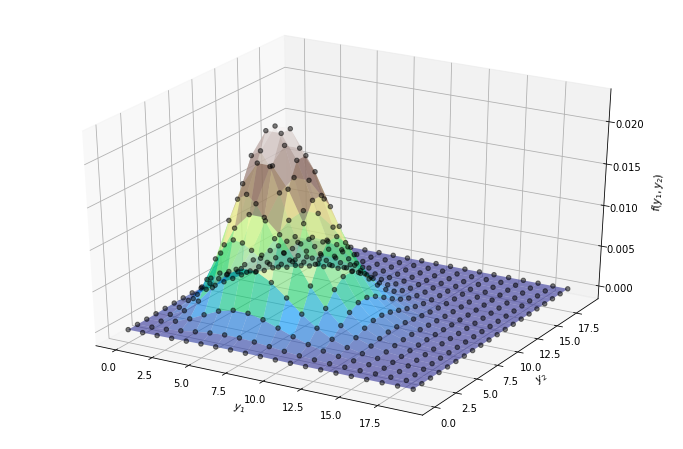

In [4]:
# Simulate Poisson joint distribution
def plot_joint_poisson(μ=7, y_n=20):
    yi_values = np.arange(0, y_n, 1)
    X, Y = np.meshgrid(yi_values, yi_values)

    # Multiply distributions together: assume y1 is independent of y2
    Z = poisson_pmf(X, μ) * poisson_pmf(Y, μ)

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z.T, cmap='terrain', alpha=0.6)
    ax.scatter(X, Y, Z.T, color='black', alpha=0.5, linewidths=1)
    ax.set(xlabel='$y_1$', ylabel='$y_2$')
    ax.set_zlabel('$f(y_1, y_2)$', labelpad=10)
    plt.show()

plot_joint_poisson(μ=7, y_n=20)

The likelihood function is the same as the joint pmf, but treats the parameter β as a random variable and takes the observations (yi, xi) as given.  
Our goal is to find the β̂ that yields the maximum likelihood value.  
From Calculus, we know maximum likelihood value occurs when the first derivative euqals to 0.  
We can find this value by Newton-Raphson method.  

In [5]:
def newton_raphson(model, tol=1e-3, max_iter=1000, display=True):

    i = 0
    error = 100  # Initial error value

    # Print header of output
    if display:
        header = f'{"Iteration_k":<13}{"Log-likelihood":<16}{"θ":<60}'
        print(header)
        print("-" * len(header))

    # While loop runs while any value in error is greater
    # than the tolerance until max iterations are reached
    while np.any(error > tol) and i < max_iter:
        H, G = model.H(), model.G()
        β_new = model.β - (np.linalg.inv(H) @ G)
        error = β_new - model.β
        model.β = β_new

        # Print iterations
        if display:
            β_list = [f'{t:.3}' for t in list(model.β.flatten())]
            update = f'{i:<13}{model.logL():<16.8}{β_list}'
            print(update)

        i += 1

    print(f'Number of iterations: {i}')
    print(f'β_hat = {model.β.flatten()}')

    # Return a flat array for β (instead of a k_by_1 column vector)
    return model.β.flatten()

In [6]:
# Define our PoissonRegression model
class PoissonRegression:

    def __init__(self, y, X, β):
        self.X = X
        self.n, self.k = X.shape
        # Reshape y as a n_by_1 column vector
        self.y = y.reshape(self.n,1)
        # Reshape β as a k_by_1 column vector
        self.β = β.reshape(self.k,1)

    def μ(self):
        return np.exp(self.X @ self.β)

    def logL(self):
        y = self.y
        μ = self.μ()
        return np.sum(y * np.log(μ) - μ - np.log(factorial(y)))

    # Gradient
    def G(self):
        y = self.y
        μ = self.μ()
        return X.T @ (y - μ)

    # Hessian
    def H(self):
        X = self.X
        μ = self.μ()
        return -(X.T @ (μ * X))

In [7]:
# Demo MLE by Newton-Raphson method and self-defined Poisson regression model
X = np.array([[1, 2, 5], [1, 1, 3], [1, 4, 2], [1, 5, 2], [1, 3, 1]])
y = np.array([1, 0, 1, 1, 0])

# Take a guess at initial βs
init_β = np.array([0.1, 0.1, 0.1])

# Create an object with Poisson model values
poi = PoissonRegression(y, X, β=init_β)

# Use newton_raphson to find the MLE
β_hat = newton_raphson(poi, display=True)

Iteration_k  Log-likelihood  θ                                                           
-----------------------------------------------------------------------------------------
0            -4.3447622      ['-1.49', '0.265', '0.244']
1            -3.5742413      ['-3.38', '0.528', '0.474']
2            -3.3999526      ['-5.06', '0.782', '0.702']
3            -3.3788646      ['-5.92', '0.909', '0.82']
4            -3.3783559      ['-6.07', '0.933', '0.843']
5            -3.3783555      ['-6.08', '0.933', '0.843']
Number of iterations: 6
β_hat = [-6.07848205  0.93340226  0.84329625]


In [8]:
# Solve Poisson regression by statsmodels
from statsmodels.discrete.discrete_model import Poisson
poisson_model = Poisson(y, X).fit()
print(poisson_model.summary())

Optimization terminated successfully.
         Current function value: 0.675671
         Iterations 7
                          Poisson Regression Results                          
Dep. Variable:                      y   No. Observations:                    5
Model:                        Poisson   Df Residuals:                        2
Method:                           MLE   Df Model:                            2
Date:                Wed, 01 Jul 2020   Pseudo R-squ.:                  0.2546
Time:                        21:45:47   Log-Likelihood:                -3.3784
converged:                       True   LL-Null:                       -4.5325
Covariance Type:            nonrobust   LLR p-value:                    0.3153
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -6.0785      5.279     -1.151      0.250     -16.425       4.268
x1             0.9334      0.